# Vectorization is the Key to Optimizing Time Complexity

## 0. Introduction

Particle physics experiments at CERN involves analyzing huge amounts of data. Without care, the codes for analyses can easily get very expensive in computational time. In this article, I will emphasize the importance of optimizing time complexity in particle experiments by comparing two versions of codes that perform identical tasks in a real life experiment. I will first briefly explain the physics and motivation behind the task that the codes perform. Then I will present two versions of the code that carry out the task. The first version uses loops that processes data one by one. The second version uses a technique called vectorization, where the code interprets arrays of data as vectors that enable parallel computation. Finally, I will plot the expended time for processing the task as a function of the size of data, as well as theoretical time expense for each version.

## 1. Physics and Motivation

This portion contains technical particle physics explanation in order to motivate the production of the code that follows. The code itself is understandable without extensive physics knowledge, so feel free to skip this section if wanted.

At the Large Hadron Collider (LHC) at CERN, about hundred billion protons collide each other every 25 nanoseconds. Each collision produces around 1MB of data, leading to producing about 4 TB fo data every second! Each process of proton-proton collision, followed by the production and decay of various particles, and their subsequent detection is called an <b>event</b>. Physicists investigate on what happened in an event by looking at the data produced when particles hit or pass through a detector, such as the Compact Muon Solenoid (CMS). The issue with the computers and storage system is the vast size of data being produced. Due to the limitations in computing speed and storage space, it is not feasible to store all events that are produced. Even if that is possible, later analyses will be impractical as we would need to filter out many events that are not of interest. This requires us to devise a system to quickly discern whether an event is worthy for further investigation as soon as the event is redorded, and discard if it is not important. This system is called "trigger". The role of a trigger is cruicial as it must discard uninteresting events as much as possible, while retaining as much worthy events as possible, lest we never miss rare events that may contain new particles that would revolutionize physics!

Whenever a new trigger algorithm is introduced, one must perform an efficiency study of the new trigger. The efficiency is calculated by taking a fraction of the number of events that passed the trigger (saved) from the number of events that should pass the trigger. The trigger that we will be testing here is called the VBF (Vector-Boson Fusion) trigger that, as its name suggests, sensitively selects the VBF events. VBF is a process where each of two incoming quarks radiate a vector boson (a $W$ or a $Z$), followed by the fusion of the vector bosons to produce an electroweak boson or a Higgs. Efficiently selecting and saving these VBF events enables extensive studies about Higgs boson and new physics related to it, so it is important to study the efficiency of VBF trigger and optimize it. Achieving this involvles comparing the jets that are recontructed at the trigger level and those that are reconstructed offline. The values such as their momenta or mass, or even the number of objects are slightly different since two reconstruction algorithms are different. This imposes a challenge when assigning a value stored in one object, say the trigger-level jet, to the corresponding object at the offline level. One might incline to compare individual jet by jet, but that would take an astronomical amount of time, as will be shown in subsequent sections. Thus, one should devise a clever method to incorporate vectorization when implementing the task.

## 2. The Task

Here are two objects named ```offline_jets``` and ```trigger_jets```. Both objects contain information about a physics object called jet, but the jets contained in these two objects differ since two different algorithms are implemented to measure the jet quantities such as the number of jets or momenta. I extracted only the relevant quantities that indicate the angular position of the jets, i.e., the pseudorapidity ($\eta$, similar to polar angle in spherical coordinates) and the azimuthal angle ($\phi$). Let's take a look at some features of the data.

In [16]:
import json
import numpy as np
import awkward as ak
from time import perf_counter
import matplotlib.pyplot as plt

In [17]:
offline_jets = ak.from_parquet("offline_jets.parquet")
trigger_jets = ak.from_parquet("trigger_jets.parquet")

print(f"Number of events: {len(offline_jets)}")
print(f"Number of offline_jets in event 0: {ak.num(offline_jets)[0]}")
print(f"Number of trigger_jets in event 0: {ak.num(trigger_jets)[0]}")
print(f"Information of a jet from offline_jets in event 0: {offline_jets[0][0]}")
print(f"Information of a jet from trigger_jets in event 0: {trigger_jets[0][0]}")

Number of events: 2945633
Number of offline_jets in event 0: 18
Number of trigger_jets in event 0: 2
Information of a jet from offline_jets in event 0: {eta: 2.63, phi: -2.95}
Information of a jet from trigger_jets in event 0: {id: 1, filterBits: 1, eta: 2.63, phi: -2.96}


We can see that there are many million events, and each event contains ones to tens of jets. Each jet contains their information on angular distribution in the form of Python dictionary, as well as the quantity called ```id``` and ```filterBits``` in ```trigger_jets```. The task is to manually compare the angular distribution between ```offline_jets``` and ```trigger_jets```, and assign the ```id``` and ```filterBits``` from ```trigger_jets``` to the matching ```offline_jets```. The figure of merit for jet-matching is called $dR$, and it is defined as follows:
$$
    dR = \sqrt{(\eta_{trigger}-\eta_{offline})^2+(\phi_{trigger}-\phi_{offline})^2}
$$
which is analogous to the distance formula in Cartesian coordinates. We will assume that there is always a jet in ```trigger_jets``` that match with a jet in ```offline_jets``` (this is not true in actual experiment, so there has to be a maximum $dR$ at which the matching takes place and otherwise forfeit the matching), so we can safely match the jets that produce minimum $dR$. In the case above, we can confidently say even by inspection that the ```offline_jet``` being printed matches with the ```trigger_jets``` being printed, as the $\eta$ and $\phi$ values of two jets are very close. However, this is not always the case. For example, consider the following event:

In [18]:
print(f"trigger_jets.eta: {trigger_jets.eta[427]}")
print(f"trigger_jets.phi: {trigger_jets.phi[427]}")
print(f"offline_jets.eta: {offline_jets.eta[427]}")
print(f"offline_jets.phi: {offline_jets.phi[427]}")

trigger_jets.eta: [-3.12, 3.32, -1.3]
trigger_jets.phi: [-2.26, -0.879, 1.14]
offline_jets.eta: [-1.29, -3.09, 3.66, 3.02, -0.752, 0.325]
offline_jets.phi: [1.15, -2.24, -1.27, -1.02, 1.07, 0.659]


In this event, the first jet in ```trigger_jets``` matches the second jet in ```offline_jets```, not the first one. The third jet in ```trigger_jets``` matches the first jet in ```offline_jets```. Furthermore, we are not even sure by inspection whether the second jet in ```trigger_jets``` should match the third or the fourth jet in ```offline_jets```. The fact that jet-mathing is not necessarily columnar and that there are instances where jet-matching is ambiguous, we need to devise a stable code that checks the $dR$ of all combinations of jets and flexibly assigns the ```id``` and ```filterBits``` to appropriate ```offline_jets```.

<style>
  .custom-font {
    font-family: "menlo", monospace;
  }
</style>

<p class="custom-font">
trigger_jets.eta: [<span style="color:blue">-3.12</span>, <span style="color:red">3.32</span>&nbsp;&nbsp;, <span style="color:green">-1.3</span>]

<p class="custom-font">
trigger_jets.phi: [<span style="color:blue">-2.26</span>, <span style="color:red">-0.879</span>, <span style="color:green">1.14</span>]

<p class="custom-font">
offline_jets.eta: [<span style="color:green">-1.29</span>, <span style="color:blue">-3.09</span> , <span style="color:red">3.66</span> , <span style="color:red">3.02</span> , -0.752, 0.325]

<p class="custom-font">
offline_jets.phi: [<span style="color:green">1.15</span> , <span style="color:blue">-2.24</span> , <span style="color:red">-1.27</span>, <span style="color:red">-1.02</span>, 1.07&nbsp;&nbsp;, 0.659]

The blue and green-colored jets are matched by inspection, but they are not columnar; we can't confidently match the red-colored jet in ```trigger_jets``` to either one of red-colored jets in ```offline_jets```.

### Loops

The most intuitive way to carry out this task is to use loops. Using loops, we can process the tasks event-by-event and jet-by-jet. Here is a function named ```AssignByLoops``` that calculates $dR$ s and assigning filterBits to appropriate jets.

In [19]:
def AssignByLoops(offline_jets, trigger_jets, event_num=-1):
    offline_jets = offline_jets[:event_num]
    trigger_jets = trigger_jets[:event_num]
    
    # Step 1: Calculating dRs
    ti_dR = perf_counter()
    dRs = np.zeros(len(trigger_jets),dtype=object)

    # looping over events
    for event in range(len(dRs)):
        dRs[event] = np.zeros(len(trigger_jets[event]),dtype=object)
        
        # looping over trigger_jets
        for t, trigger_jet in enumerate(trigger_jets[event]):
            dRs[event][t] = np.zeros(len(offline_jets[event]))
            
            # looping over offline_jets
            for j, offline_jet in enumerate(offline_jets[event]):
                dR = np.sqrt((trigger_jet.eta-offline_jet.eta)**2 + (trigger_jet.phi-offline_jet.phi)**2)
                dRs[event][t][j] = dR
    tf_dR = perf_counter()

    # Step 2: Producing array of filterBits
    ti_fB = perf_counter()
    filterBitsToAdd = list(np.zeros(len(dRs),dtype=object))

    # looping over events
    for event in range(len(dRs)):
        filterBitsToAdd[event] = list(np.full(len(offline_jets[event]),-999))

        # looping over trigger_jets
        for trigjet in range(len(dRs[event])):
            min_index = ak.argmin((dRs[event][trigjet]))
            filterBitsToAdd[event][min_index] = trigger_jets[event][trigjet].filterBits
    tf_fB = perf_counter()

    # Step 3: Assigning filterBits to appropriate jets
    offline_jets = ak.with_field(offline_jets, filterBitsToAdd, "filterBits")

    # Recording times
    t_dR  = tf_dR - ti_dR
    t_fB  = tf_fB - ti_fB
    t_tot = tf_fB - ti_dR
    return offline_jets, t_dR, t_fB, t_tot

The function might look confusing, but it becomes clear once we break down and inspect it step by step. The function is comprised of three steps: calculating dRs, producing array of filterBits, and assigning filterBits to appropriate jets. The third step is done with a simple built-in function in Awkward Array package, so that step is irrelevant in terms of optimizing time complexity. Both step 1 and 2 are enclosed by ```time.perf_counter``` function to measure the time consumed by each step.

In step 1, we loop over the events, then access ```trigger_jets``` and ```offline_jets``` with their own respective loops to create combinations between the jets. We then calculate the $dR$ s for each combination and store the values to ```dRs```. The time spent in step 1 can be expressed as following:
$$
    t_{1} = t_{dR} \times \overline{N}_{offjet} \times t_{trigjet} \times \overline{N}_{trigjet} \times t_{events} \times N_{events},
$$
where each $t$ represents the time spent inside each loop, and each $\overline{N}$ represents the average number of jets in each event. Since the only thing the function does when looping over events and ```trigger_jets``` is initializing subarrays, we can disregard them by setting $t_{trigjet} = t_{events} = 1$ and regarding $t_{dR}$ as the time relative to $t_{trigjet} = t_{events}$. The expression above is then reduced to
$$
    t_{1} = t_{dR} \times \overline{N}_{offjet} \times \overline{N}_{trigjet} \times N_{events} \sim \mathcal{O}(N_{events}).
$$
We can see that $t_{1}$ will increase linearly as a function of $N_{events}$, so the time complexity of step 1 is of $\mathcal{O}(N_{events})$. Similarly, the time spent in the second step can be expressed as
$$
    t_{2} = t_{min} \times \overline{N}_{trigjet} \times N_{events} \sim \mathcal{O}(N_{events}).
$$
The total time spent in the function is
$$
    t_{Tot} = t_1 + t_2 \sim \mathcal{O}(N_{events}) + \mathcal{O}(N_{events}) \sim \mathcal{O}(N_{events}).
$$
Let's see if this is true by plotting the time spent by ```AssignByLoops``` as a function of number of events.

In [21]:
loop_t_dRs, loop_t_fBs, loop_t_tots = [], [], []
event_nums = [2000000, 665484, 221434, 73680, 24516, 8157, 2714, 903, 300, 100]

for e in event_nums:
    loop_offline_jets, loop_t_dR, loop_t_fB, loop_t_tot = AssignByLoops(offline_jets, trigger_jets, e)
    loop_t_dRs.append(loop_t_dR)
    loop_t_fBs.append(loop_t_fB)
    loop_t_tots.append(loop_t_tot)

timedict = {
    "event_nums": event_nums,
    "loop_t_dRs": loop_t_dRs,
    "loop_t_fBs": loop_t_fBs, 
    "loop_t_tots": loop_t_tots,
}
with open('times.json', 'w') as f: json.dump(timedict, f, indent=4)

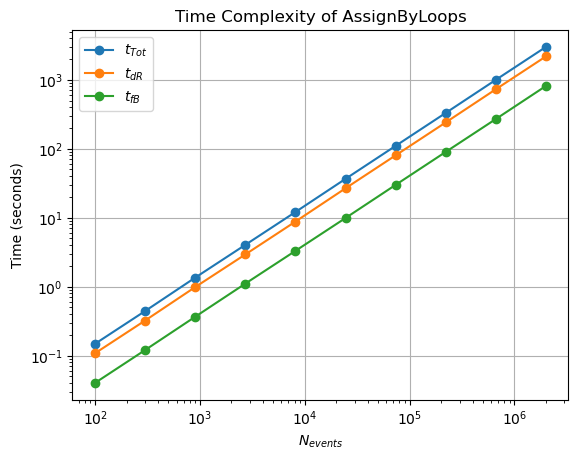

In [11]:
times = json.load(open('times.json', 'r'))
event_nums, loop_t_tots, loop_t_dRs, loop_t_fBs = times["event_nums"], times["loop_t_tots"], times["loop_t_dRs"], times["loop_t_fBs"]

plt.loglog(event_nums, loop_t_tots, '-o', label=r"$t_{Tot}$")
plt.loglog(event_nums, loop_t_dRs , '-o', label=r"$t_{dR}$")
plt.loglog(event_nums, loop_t_fBs , '-o', label=r"$t_{fB}$")
plt.title("Time Complexity of AssignByLoops")
plt.xlabel(r"$N_{events}$")
plt.ylabel(r"Time (seconds)")
plt.grid()
plt.legend()

We can see that the time complexity matches the theoretical prediction. As the number of events becomes larger than a million, over thousand seconds are required to process all events, which is over half an hour! In realistic experiments involving billion events, the looping process will clearly be not ideal.

### Vectors

It becomes obviously cumbersome to execute the program as the size of data gets large. We need to devise a code that is more optimal than $\mathcal{O}(N)$. Here is the code for assigning filterBits using vectorization.

In [22]:
def AssignByVector(offline_jets, trigger_jets, event_num=-1):
    offline_jets = offline_jets[:event_num]
    trigger_jets = trigger_jets[:event_num]

    # Step 1: Calculating dRs
    ti_dR = perf_counter()
    TrigOFFcombo = ak.cartesian({"tri": trigger_jets, "off": offline_jets[:,np.newaxis]})
    dRs = np.sqrt((TrigOFFcombo.tri.eta-TrigOFFcombo.off.eta)**2 + (TrigOFFcombo.tri.phi-TrigOFFcombo.off.phi)**2)
    tf_dR = perf_counter()

    # Step 2: Producing array of filterBits
    ti_fB = perf_counter()
    mindRindex = ak.argmin(dRs,axis=-1)
    filterBitsToAdd = np.full(np.shape(ak.pad_none(offline_jets.eta,ak.max(ak.num(offline_jets.eta))+1,axis=-1)),-999)
    event_index = np.expand_dims(np.arange(len(filterBitsToAdd)),-1)
    mindRindex = ak.fill_none(ak.pad_none(mindRindex,ak.max(ak.num(mindRindex))),-1)
    filterBits = ak.fill_none(ak.pad_none(trigger_jets.filterBits,ak.max(ak.num(trigger_jets.filterBits))),-999)

    filterBitsToAdd[event_index,mindRindex] = filterBits
    
    shape_preservation = ak.full_like(offline_jets.eta,True,dtype=bool)
    shape_preservation = ak.fill_none(ak.pad_none(shape_preservation,ak.max(ak.num(offline_jets))+1),False)
    filterBitsToAdd = ak.Array(filterBitsToAdd)[shape_preservation]
    tf_fB = perf_counter()

    # Step 3: Assigning filterBits to appropriate jets
    offline_jets = ak.with_field(offline_jets, filterBitsToAdd, "filterBits")

    # Recording times
    t_dR  = tf_dR - ti_dR
    t_fB  = tf_fB - ti_fB
    t_tot = tf_fB - ti_dR
    return offline_jets, t_dR, t_fB, t_tot

```AssignByVector``` does the same thing as ```AssignByLoops```, but it uses multiple vectorizations along the way. The code might seem more unintuitive than before, but it exploits some amazing features of indexing and dimensional operations featured in NumPy an Awkward Array packages. Let's look at the function line by line how vectorization is achieved.

First, we make pairs among ```trigger_jets``` and ```offline_jets``` for each and all events, and store it to ```TrigOFFcombo```. We then create ```dRs``` in an array-level, instead of looking at each pair. This requires replicating all offline_jets in an event a number of times equal to the number of ```trigger_jets```. Although it requires more spatial complexity, enabling vectorization in calculating ```dRs``` significantly reduces the time.

Step 2 requires a regular-sized NumPy array, because we are going to exploit the indexing feature of NumPy that is not encoded in Awkward Array. NumPy array allows the indexing argument to be multi-dimensional. In this task, we want to select a flexible number of elements in a flexible order for each event, for the reason explained above (that the jet-matching is not columnar). NumPy indexing in the format ```[:,x]``` acts in each dimension: ':' selects each event (0th dimension), and x selects the xth element for each event. If we put a 2D array X instead of x, then we can select any number of elements (specified by the number of elements in X) at any order. For example, if ```X = [[0,1],[2],[1,0]]```, and first three events are specified by ```arr =  [[a,b,c],[d,e,f,g],[h,i]]```, then ```arr[X] == [[a,b],[f],[i,h]]```. We are exploiting this feature of NumPy array indexing. The shortcoming of using NumPy arrays is that it does not allow variable lengths of subarrays, so I first declared ```filterBitsToAdd``` as a rectangularized array, and later introduced ```shape_preservation``` to cut ```filterBitsToAdd``` according to number of ```offline_jets```.

The process is summarized as a diagram below.

![alt text](vector_diagram.jpg "Title")

In [23]:
vect_t_dRs, vect_t_fBs, vect_t_tots = [], [], []
event_nums = [2000000, 665484, 221434, 73680, 24516, 8157, 2714, 903, 300, 100]

for e in event_nums:
    vect_offline_jets, vect_t_dR, vect_t_fB, vect_t_tot = AssignByVector(offline_jets, trigger_jets, e)
    vect_t_dRs.append(vect_t_dR)
    vect_t_fBs.append(vect_t_fB)
    vect_t_tots.append(vect_t_tot)

timedict = {
    "event_nums": event_nums,
    "vect_t_dRs": loop_t_dRs,
    "vect_t_fBs": loop_t_fBs, 
    "vect_t_tots": loop_t_tots,
}
with open('times.json', 'a') as f: json.dump(timedict, f, indent=4)

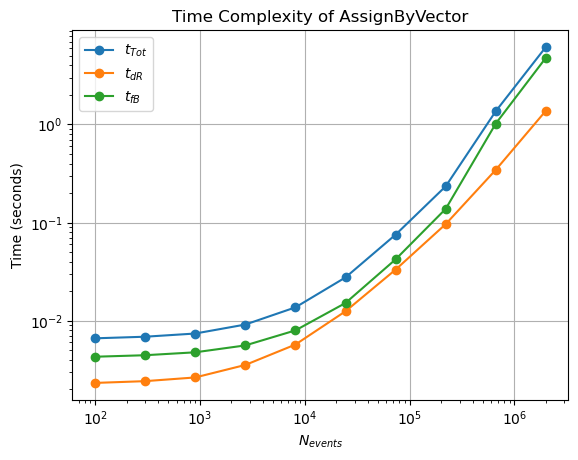

In [15]:
times = json.load(open('times.json', 'r'))
event_nums, vect_t_tots, vect_t_dRs, vect_t_fBs = times["event_nums"], times["vect_t_tots"], times["vect_t_dRs"], times["vect_t_fBs"]

plt.loglog(event_nums, vect_t_tots, '-o', label=r"$t_{Tot}$")
plt.loglog(event_nums, vect_t_dRs , '-o', label=r"$t_{dR}$")
plt.loglog(event_nums, vect_t_fBs , '-o', label=r"$t_{fB}$")
plt.title("Time Complexity of AssignByVector")
plt.xlabel(r"$N_{events}$")
plt.ylabel(r"Time (seconds)")
plt.grid()
plt.legend()

The curve itself looks like it is increasing by a steeper amount compared to loops. This may be due to a fact that as the number of events exceeds the amount that can be processed by CPU/GPU in a parallel manner, it processes as batches. Thus, the time expense is nearly constant until $N_{events}\approx3\times10^3$, but increases as a function of $N_{events}$ afterwards. In other words, if the number of events increases by a factor of 10 from the amount that can be processed in parallel, there will be 10 batches to be processed, which will result in increase of time by roughly 10 times. The time complexity thus remains the same as the looping strategy, but the amount of time reduces by a factor of the number of events that can be processed by CPU/GPU in parallel, resulting in a significantly reduced time. This becomes more apparent if we plot the time expense of both strategies in a single plot.

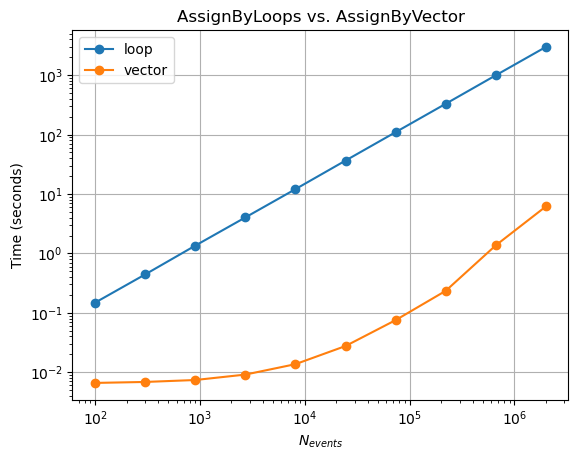

In [21]:
times = json.load(open("times.json",'r'))
event_nums = times["event_nums"]
loop_t_tots = times["loop_t_tots"]
vect_t_tots = times["vect_t_tots"]

plt.loglog(event_nums, loop_t_tots, '-o', label="loop")
plt.loglog(event_nums, vect_t_tots, '-o', label="vector")
plt.title("AssignByLoops vs. AssignByVector")
plt.xlabel(r"$N_{events}$")
plt.ylabel(r"Time (seconds)")
plt.grid()
plt.legend()

We can see that the time expense reduces by more than a factor of 100 when we utilize vectorization.

Last but not least, we should check if the filterBits are correctly assigned. Here are two events where assignings are particularly interesting. Event 427 is the same event discussed above, and event 76 is an event with a more straightforward angular distributions but more diverse filterBit values with more complicated placements.

In [25]:
# interesting events: 76, 427
print(f"Event 076 with loops: {loop_offline_jets.filterBits[76]}")
print(f"Event 076 with vects: {vect_offline_jets.filterBits[76]}")

print(f"Event 427 with loops: {loop_offline_jets.filterBits[427]}")
print(f"Event 427 with vects: {vect_offline_jets.filterBits[427]}")

Event 076 with loops: [-999, 83886178, -999, 2, 98, -999, -999]
Event 076 with vects: [-999, 83886178, -999, 2, 98, -999, -999]
Event 427 with loops: [2, 2, -999, 2, -999, -999]
Event 427 with vects: [2, 2, -999, 2, -999, -999]


We can see that the assignments through two methods agree! Now let's compare the assignment of event 076 by manually inspecting the angular distributions. 

In [31]:
print(f"Trigger fBs: {trigger_jets.filterBits[76]}")
print(f"Trigger eta: {trigger_jets.eta[76]}")
print(f"Trigger phi: {trigger_jets.phi[76]}")
print(f"Offline eta: {offline_jets.eta[76]}")
print(f"Offline phi: {offline_jets.phi[76]}")

Trigger fBs: [83886178, 98, 2]
Trigger eta: [-0.168, -2.38, 3.86]
Trigger phi: [0.203, 2.3, 0.484]
Offline eta: [-0.154, -0.175, 2.34, 3.85, -2.38, 3.96, 0.195]
Offline phi: [-2.53, 0.206, 2.33, 0.441, 2.32, 1.59, 1.52]


We can see by inspection that the first trigger_jet corresponds to the second offline_jet, the second trigger_jet to the fifth offline_jet, and the third trigger_jet to the fourth offline_jet. Thus, we expect the filterBits for event 076 to be ```[-999, 83886178, -999, 2, 98, -999, -999]```, which is exactly the result we observe above!